# Description:

    Explore options for independent filtering


# Setting variables

In [58]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [59]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [60]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [61]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

# Loading/editting OTU table

In [62]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [63]:
%%R
#remove controls
physeq = subset_samples(physeq, !is.na(Plant))


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [64]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

# Explore Filtering Functions

Create a list of taxa that meet conditions 
Use list to prune_taxa

In [65]:
%%R
m = data.frame()

s = c(.001, .005, .01, .05, .1, .2)
for(i in 1:length(s)) {
    
    sparsityThresh = s[i]
    physeq.thresh = filter_taxa(physeq, 
                                function(x) sum(x > 0) > (sparsityThresh * length(x)), TRUE)
    n = ntaxa(physeq.thresh)
    t = c(sparcityThresh,n)
    m = rbind(m,t)
    }

#tax_table(taxa)%>% head
#taxa  

#ntaxa(physeq.thresh)
#  
colnames(m) = c("sparcityThresh", "OTUcount")    
m


  sparcityThresh OTUcount
1          0.001    11237
2          0.005    10752
3          0.010    10493
4          0.050     8224
5          0.100     6736
6          0.200     5110


Filtering function
function(x): sum(x > 0) > (0.2 * length(x)), TRUE): 5110 taxa
Store taxa list in variable

## Stage 1: List of taxa to passing sparsity filter

In [66]:
%%R
physeq.thresh = filter_taxa(physeq, 
                 function(x) sum(x > 0) > (.2 * length(x)), TRUE)

In [67]:
%%R
##use taxa_names as a list of OTUs to prune physeq object
TwentypercentTaxa = taxa_names(physeq.thresh)
test = prune_taxa(TwentypercentTaxa, physeq)
test

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5110 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 5110 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5110 tips and 5109 internal nodes ]


In [143]:
%%R
str(TwentypercentTaxa)

 chr [1:5110] "OTU.5899" "OTU.8680" "OTU.2666" "OTU.323" ...


## Stage 2:  List of OTUs that are in at least half of a  a fraction of a genotype's plots

In [68]:
%%R
levels(sample_data(physeq)$Plant)

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "BARE"   "ECHCG"  "ELCOR" 
 [9] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[17] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [100]:
%%R

Plants = levels(sample_data(physeq)$Plant)
CoreCheck = vector()
pm = data.frame(length(Plants), 2)

for (i in 1:length(Plants)) {
    plant = Plants[i]
    physeq.p = subset_samples(physeq, Plant == plant)
    
    physeq.thresh = filter_taxa(physeq.p, 
                             function(x) sum(x > 0) > (.5 * length(x)), TRUE)

#Generate table of number of OTUs kept for each 
    n = ntaxa(physeq.thresh)
    t = c(plant,n)
    pm[i,] = t

    plantcore = taxa_names(physeq.thresh)
    CoreCheck = c(CoreCheck, plantcore)                                
    }
colnames(pm) = c("Plant", "OTUcount")

In [101]:
%%R
pm

    Plant OTUcount
1  75-062     3036
2   ABUTH     1435
3   AMAPO     2107
4     B73     2957
5     B97     3122
6    BARE     3635
7   ECHCG     1705
8   ELCOR     1393
9   ERATE     2784
10  FAGES     3174
11  GLYMA     1741
12    H99     2655
13  HELAN     1107
14  Hp301     1469
15  Il14H     3488
16    Ki3     1564
17   Mo18     1502
18   MS71     3761
19   Oh7B     3548
20  SETFA     2831
21  SORBI     1412
22 SORSUD     1388
23  Tx303     2067


In [103]:
%%R
CoreList = unique(CoreCheck) 
length(CoreList)

[1] 5218


## Combine lists and use combined list to prune phyloseq object

In [106]:
%%R
TaxaList = unique(c(TwentypercentTaxa, CoreList))
length(TaxaList)
TaxaList[1:10]

 [1] "OTU.5899"  "OTU.8680"  "OTU.2666"  "OTU.323"   "OTU.7636"  "OTU.3772" 
 [7] "OTU.1030"  "OTU.1622"  "OTU.11892" "OTU.1212" 


In [119]:
%%R
str(TaxaList)

 chr [1:5477] "OTU.5899" "OTU.8680" "OTU.2666" "OTU.323" ...


In [125]:
%%R
write(TaxaList, file = "OTUs_PassedFilter.txt",
      ncolumns = if(is.character(TaxaList)) 1 else 5,
      append = FALSE, sep = "\t")


### Read vector and use to prune physeq object

In [144]:
%%R
test = read.delim(file = "OTUs_PassedFilter.csv", header = FALSE, sep = "\t")
PruneList = as.character(test[,1])

In [145]:
%%R
physeq.if = prune_taxa(PruneList, physeq)
physeq.if

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5477 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 5477 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5477 tips and 5476 internal nodes ]


# Compare filtered vs unfiltered 

In [147]:
%%R
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.if.snorm = transform_sample_counts(physeq.if, function(x) x/sum(x))

In [152]:
%%R
colnames(tax_table(physeq.if.snorm)) = c("Kingdom", "Phylum",  "Class",   "Order",   
                         "Family",  "Genus",   "Species", "Strain")

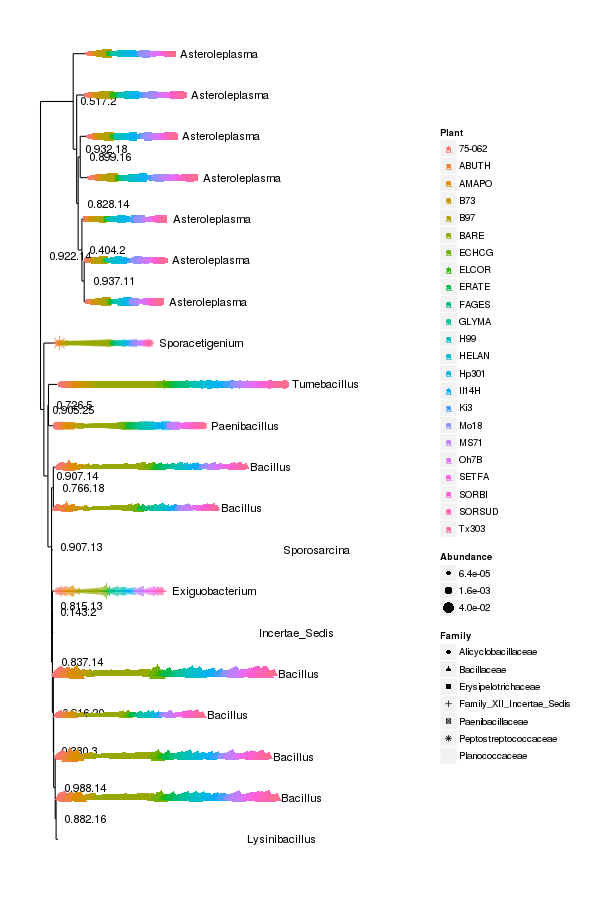

In [153]:
%%R -w 600 -h 900
Rhiz.f = subset_taxa(physeq.if.snorm, Phylum == "Firmicutes")
topNOTUs = names(sort(taxa_sums(Rhiz.f), TRUE)[1:20])
Rhiz.ft = prune_taxa(topNOTUs, Rhiz.f)
plot_tree(Rhiz.ft, color = "Plant", shape = "Family", label.tips = "Genus", 
          size = "abundance", plot.margin = 0.5, ladderize = TRUE)

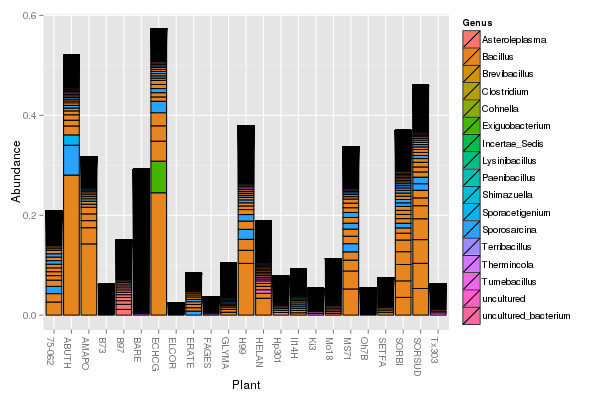

In [154]:
%%R -w 600 -h 400
p1 = plot_bar(Rhiz.f, x="Plant", fill="Genus")

#pdf("firmicutes_relabund.pdf")
p1
#dev.off()